In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import polars as pl
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import (
    precision_recall_curve, precision_recall_fscore_support,
    average_precision_score, roc_auc_score,
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

from pandas.api.types import is_numeric_dtype, is_bool_dtype, is_categorical_dtype, is_string_dtype

from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

In [38]:
eval = pd.read_csv("data/extrait_eval.csv")
sirh = pd.read_csv("data/extrait_sirh.csv")
sondage = pd.read_csv("data/extrait_sondage.csv")

# Partie d'exploration de la forme de chaque fichier

Cette partie de code explore la forme des données et retype certaines variables

In [ ]:
eval.info()
sirh.info()
sondage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64(7), object(3)
memory usage:

In [42]:
sirh["nombre_heures_travailless"] = sirh["nombre_heures_travailless"].astype("object")
sondage["nombre_employee_sous_responsabilite"] = sondage["nombre_employee_sous_responsabilite"].astype("object")

 # test des doublons

In [43]:
print(eval.loc[eval[['eval_number']].duplicated(keep=False),:])
print(sirh.loc[sirh[['id_employee']].duplicated(keep=False),:])
print(sondage.loc[sondage[['code_sondage']].duplicated(keep=False),:])

Empty DataFrame
Columns: [satisfaction_employee_environnement, note_evaluation_precedente, niveau_hierarchique_poste, satisfaction_employee_nature_travail, satisfaction_employee_equipe, satisfaction_employee_equilibre_pro_perso, eval_number, note_evaluation_actuelle, heure_supplementaires, augementation_salaire_precedente]
Index: []
Empty DataFrame
Columns: [id_employee, age, genre, revenu_mensuel, statut_marital, departement, poste, nombre_experiences_precedentes, nombre_heures_travailless, annee_experience_totale, annees_dans_l_entreprise, annees_dans_le_poste_actuel]
Index: []
Empty DataFrame
Columns: [a_quitte_l_entreprise, nombre_participation_pee, nb_formations_suivies, nombre_employee_sous_responsabilite, code_sondage, distance_domicile_travail, niveau_education, domaine_etude, ayant_enfants, frequence_deplacement, annees_depuis_la_derniere_promotion, annes_sous_responsable_actuel]
Index: []


# créaction des colonnes pour la jointure des trois fichier puis jointure dans un fichir data

In [44]:
eval["key"] = pd.to_numeric(
    eval["eval_number"].astype("string").str.replace(r"^E[_-]?", "", regex=True),
    errors="coerce"
).astype("Int64")

sirh["key"] = pd.to_numeric(sirh["id_employee"], errors="coerce").astype("Int64")
sondage["key"] = pd.to_numeric(sondage["code_sondage"], errors="coerce").astype("Int64")

In [45]:
data = (
    eval.merge(
        sirh, on="key", how="outer",
        suffixes=("", "_sirh"),
        validate="one_to_one",
        indicator="_merge_eval_sirh"
    ).merge(
        sondage, on="key", how="outer",
        suffixes=("", "_sond"),
        validate="one_to_one"  
    )
)

data["key"] = data["key"].astype("category")  # identifiant ≠ feature numérique
s = data["augementation_salaire_precedente"].astype(str).str.strip()
num = s.str.extract(r'(\d+[.,]?\d*)', expand=False)
data["augmentation_pct"] = pd.to_numeric(
    num.str.replace(",", ".", regex=False), errors="coerce"
) / 100.0
data["augmentation_pct"] = data["augmentation_pct"].fillna(0.0)
data.drop(columns=["augementation_salaire_precedente"], inplace=True, errors="ignore")

In [46]:
data.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,key,...,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,augmentation_pct
0,2,3,2,4,1,1,E_1,3,Oui,1,...,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,0.11
1,3,2,2,2,4,3,E_2,4,Non,2,...,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,0.23
2,4,2,1,3,2,3,E_4,3,Oui,4,...,1,4,2,2,Autre,Y,Occasionnel,0,0,0.15
3,4,3,1,3,3,3,E_5,3,Oui,5,...,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,0.11
4,1,3,1,2,4,3,E_7,3,Non,7,...,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,0.12


# Code pour l'exploration de chacune des variables selon le type de variable

In [47]:
#Affichage des informations selon le type de variable qualitatives ou quantitaves

for col in data.columns:
    print(f"### Colonne : {col}\n")
        
    if data[col].dtype == "object" or str(data[col].dtype) == "category":
        print("Variable qualitative\n")
        print(data[col].value_counts(dropna=False))
    else:
        print("Variable quantitative\n")
        print(data[col].describe())
        
    print("\n" + "-"*50 + "\n")

### Colonne : satisfaction_employee_environnement

Variable quantitative

count    1470.000000
mean        2.721769
std         1.093082
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: satisfaction_employee_environnement, dtype: float64

--------------------------------------------------

### Colonne : note_evaluation_precedente

Variable quantitative

count    1470.000000
mean        2.729932
std         0.711561
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: note_evaluation_precedente, dtype: float64

--------------------------------------------------

### Colonne : niveau_hierarchique_poste

Variable quantitative

count    1470.000000
mean        2.063946
std         1.106940
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: niveau_hierarchique_poste, dtype: float64

-------------------------------

# Suppression des variables inutiles

In [ ]:
del data["eval_number"]
del data["key"]
del data["id_employee"]
del data["nombre_heures_travailless"]
del data["_merge_eval_sirh"]
del data["nombre_employee_sous_responsabilite"]
del data["code_sondage"]
del data["ayant_enfants"]

# Exploration graphique des données

En premier un matrice de corrélation est réalisé

En suivant un utilitaire est créé pour afficher un ensemble de graphique selon le type de variable pour voir le lien avec la variable cible 

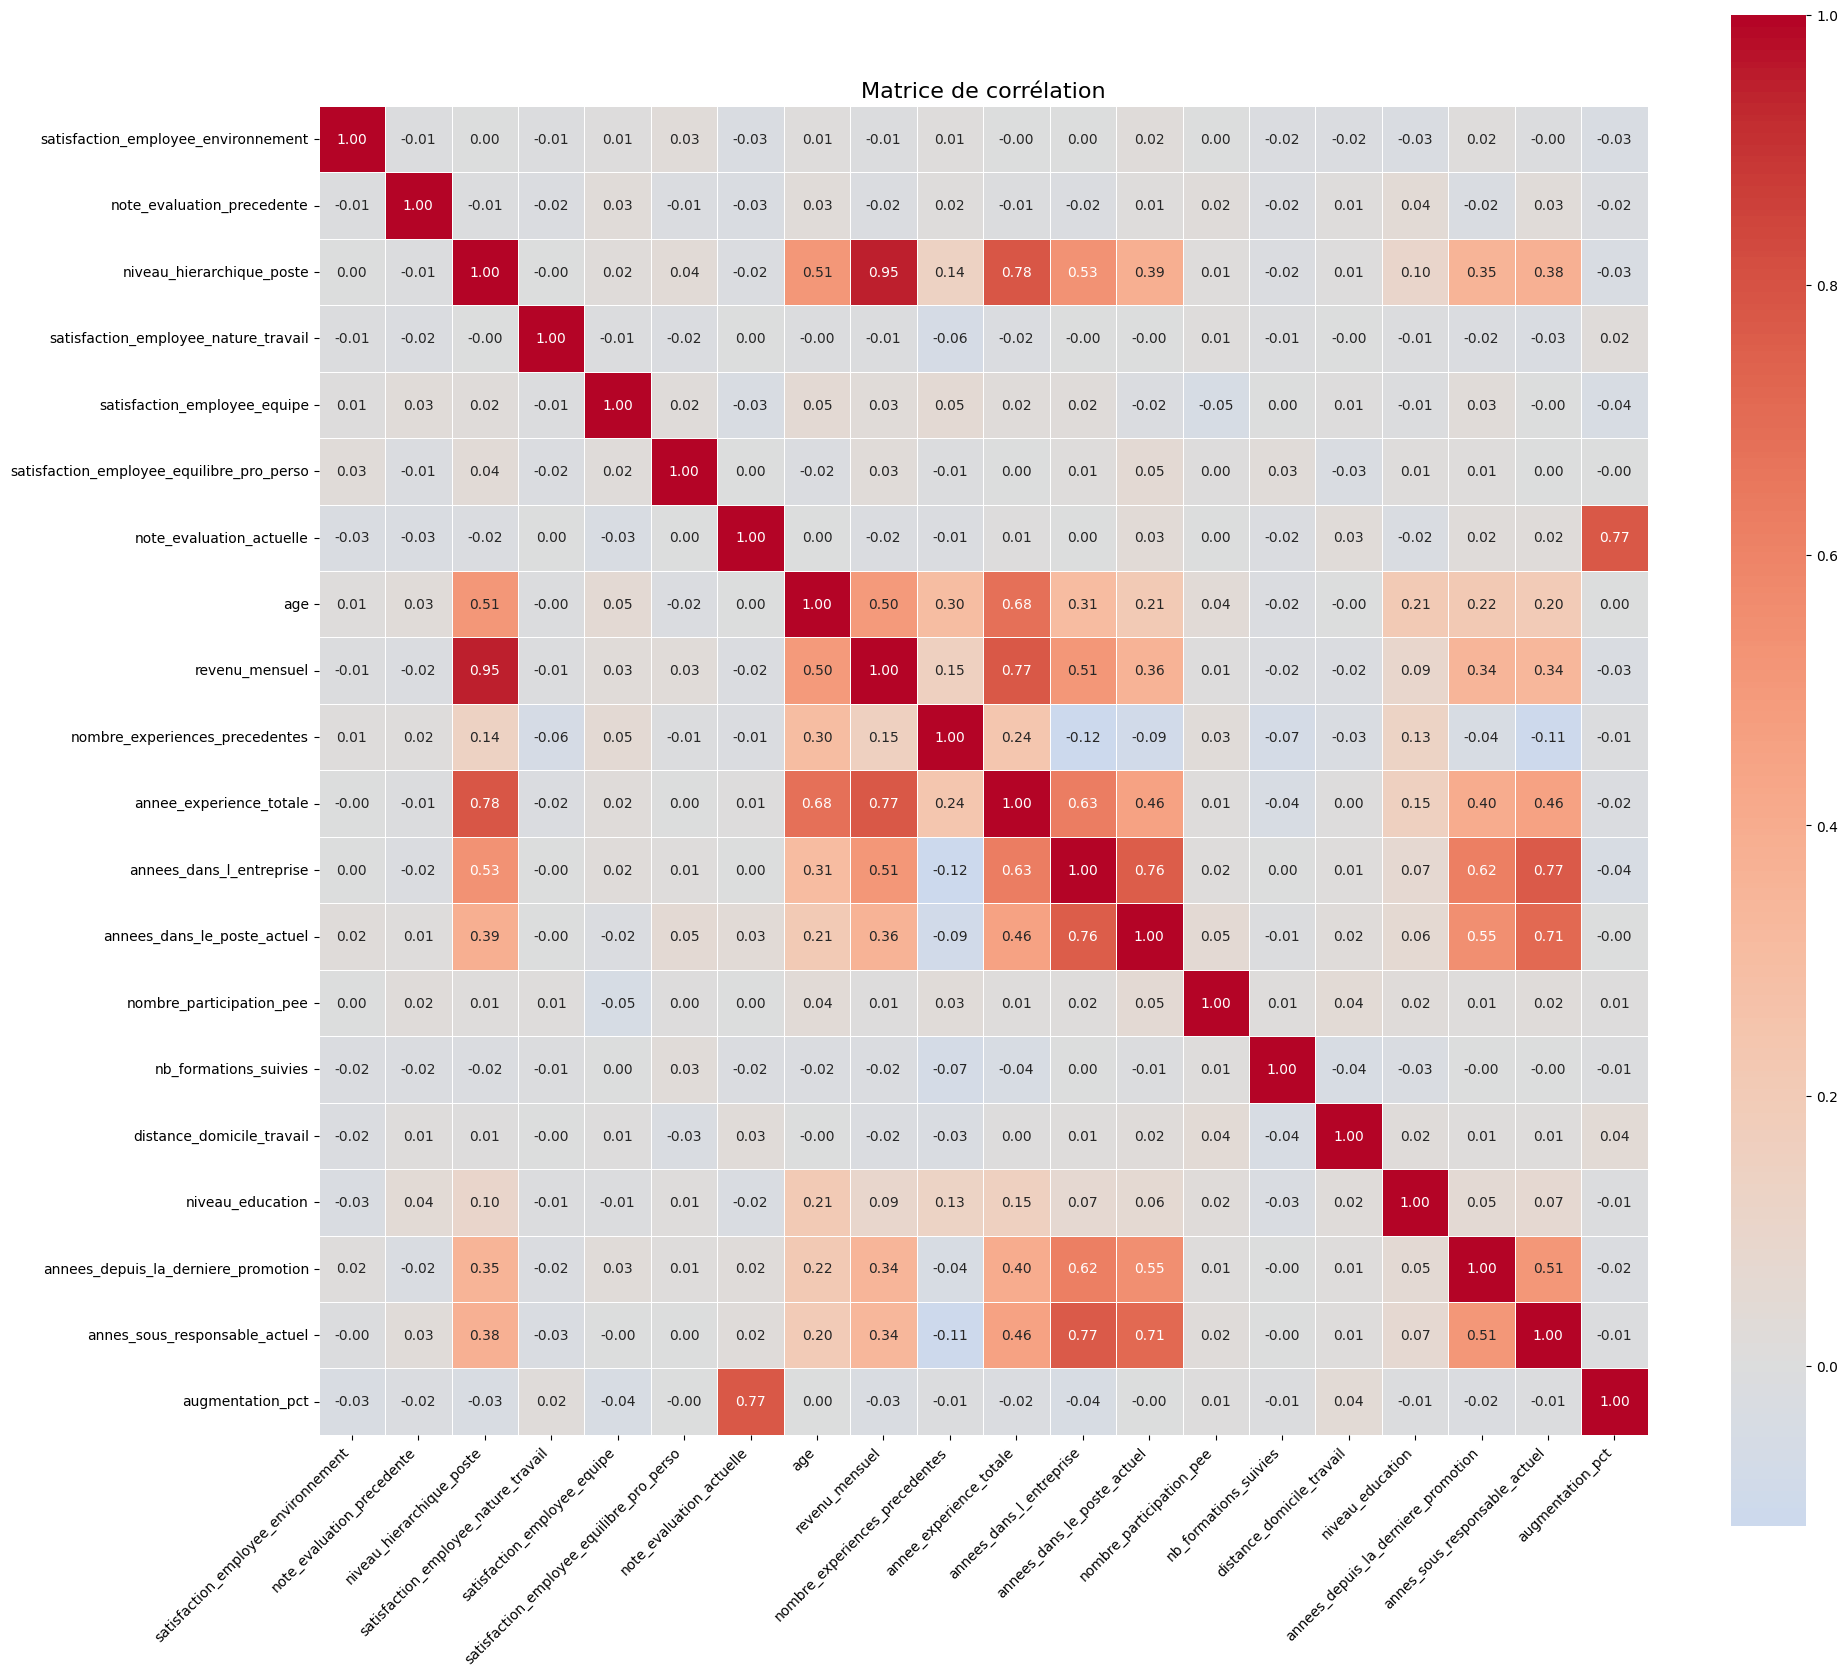

In [49]:
matrice_correlation_pearson = (
     data.corr(method='pearson', numeric_only=True)
)

plt.figure(figsize=(20, 20))

sns.heatmap(
    matrice_correlation_pearson,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title(
    "Matrice de corrélation",
    fontsize=16
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [53]:
def auto_plots(
    df: pd.DataFrame,
    target: str | None = None,
    id_cols: list[str] | None = None,
    top_n: int = 20,
    bins: str | int = "auto",              # conservé pour compat, peu utilisé avec les scatters
    figsize_num: tuple[int, int] = (9, 5),
    figsize_cat: tuple[int, int] = (9, 5),
):
    """
    Trace automatiquement des graphiques:
    - Variables qualitatives -> barplots (+ empilé vs target si fourni)
    - Variables numériques discrètes (<=10 modalités) -> barplots (+ empilé vs target)
    - Variables numériques continues:
        * si target numérique: scatter (ou hexbin si très gros)
        * si target binaire: scatter avec jitter vertical autour de 0/1
        * si target multi-classes: "strip scatter" (codes de classes en Y)
        * si pas de target: dot plot ordonné (valeur vs rang) + rug plot
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pandas.api.types import (
        is_bool_dtype, is_categorical_dtype, is_string_dtype, is_numeric_dtype
    )

    if id_cols is None:
        id_cols = []
    cols = [c for c in df.columns if c not in id_cols]

    for col in cols:
        s = df[col]

        # ignorer colonnes vides/constantes
        try:
            if s.nunique(dropna=False) <= 1:
                continue

            # Détecter qualitatif vs numérique
            is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)

            if is_qual:
                counts = s.astype("object").fillna("NA").value_counts().head(top_n)

                plt.figure(figsize=figsize_cat)
                counts.plot(kind="bar")
                plt.title(f"{col} — top {min(top_n, counts.shape[0])} modalités (effectifs)")
                plt.xlabel(col); plt.ylabel("Effectif")
                plt.xticks(rotation=45, ha="right")
                plt.tight_layout(); plt.show()

                if target and target in df.columns:
                    order = counts.index
                    ctab = pd.crosstab(
                        s.astype("object").fillna("NA"),
                        df[target].astype("object").fillna("NA"),
                        normalize="index"
                    )
                    ctab = ctab.loc[order.intersection(ctab.index)]
                    plt.figure(figsize=figsize_cat)
                    ctab.plot(kind="bar", stacked=True)
                    plt.title(f"{col} — répartition de {target} par modalité (normalisée)")
                    plt.xlabel(col); plt.ylabel("Proportion")
                    plt.legend(title=target, bbox_to_anchor=(1.02, 1), loc="upper left")
                    plt.tight_layout(); plt.show()

            elif is_numeric_dtype(s):
                # Variables numériques
                # Cas "discret": <=10 valeurs distinctes
                if s.nunique(dropna=True) <= 10:
                    counts = s.value_counts(dropna=False).sort_index()
                    plt.figure(figsize=figsize_num)
                    counts.plot(kind="bar")
                    plt.title(f"{col} — effectifs (numérique discret)")
                    plt.xlabel(col); plt.ylabel("Effectif")
                    plt.xticks(rotation=0)
                    plt.tight_layout(); plt.show()

                    if target and target in df.columns:
                        order = counts.index
                        ctab = pd.crosstab(
                            s, df[target].astype("object").fillna("NA"),
                            normalize="index"
                        )
                        ctab = ctab.loc[order.intersection(ctab.index)]
                        plt.figure(figsize=figsize_num)
                        ctab.plot(kind="bar", stacked=True)
                        plt.title(f"{col} — répartition de {target} (discret, normalisée)")
                        plt.xlabel(col); plt.ylabel("Proportion")
                        plt.legend(title=target, bbox_to_anchor=(1.02, 1), loc="upper left")
                        plt.tight_layout(); plt.show()

                else:
                    # Variables numériques continues -> privilégier des "nuages"
                    arr = s.to_numpy()
                    # Index non-NaN sur la feature
                    idx_feat = s.dropna().index

                    if target and target in df.columns:
                        t = df[target]

                        # 1) target NUMÉRIQUE -> vrai scatter (x=feature, y=target)
                        if is_numeric_dtype(t):
                            # aligne x/y sur les index non-NaN communs
                            idx_common = idx_feat.intersection(t.dropna().index)
                            if len(idx_common) == 0:
                                continue
                            x = df.loc[idx_common, col].to_numpy()
                            y = df.loc[idx_common, target].to_numpy()

                            plt.figure(figsize=figsize_num)
                            if len(idx_common) > 5000:
                                plt.hexbin(x, y, gridsize=35)
                                plt.colorbar(label="Comptes")
                                plt.title(f"{col} vs {target} — hexbin")
                            else:
                                plt.scatter(x, y, s=8, alpha=0.5)
                                plt.title(f"{col} vs {target} — scatter")
                            plt.xlabel(col); plt.ylabel(target)
                            plt.tight_layout(); plt.show()

                        else:
                            # 2) target NON NUMÉRIQUE
                            t_obj = t.astype("object").fillna("NA")
                            classes = t_obj.unique()

                            if len(classes) == 2:
                                # binaire -> jitter vertical autour de 0/1
                                mapping = {c: i for i, c in enumerate(sorted(classes))}
                                ybin = t_obj.map(mapping)

                                idx_common = idx_feat.intersection(ybin.dropna().index)
                                if len(idx_common) == 0:
                                    continue
                                x = df.loc[idx_common, col].to_numpy()
                                y = ybin.loc[idx_common].to_numpy().astype(float)

                                rng = np.random.default_rng(42)
                                y_jit = y + rng.normal(0, 0.04, size=y.shape)

                                plt.figure(figsize=figsize_num)
                                plt.scatter(x, y_jit, s=8, alpha=0.5)
                                # labels des classes sur l'axe Y
                                inv_map = {v: k for k, v in mapping.items()}
                                plt.yticks([0, 1], [inv_map[0], inv_map[1]])
                                plt.title(f"{col} vs {target} — scatter (jitter)")
                                plt.xlabel(col); plt.ylabel(target)
                                plt.tight_layout(); plt.show()

                            else:
                                # 3) multi-classes -> "strip scatter" (jitter horizontal faible)
                                data = df.loc[idx_feat, [col, target]].dropna()
                                if data.empty:
                                    continue
                                rng = np.random.default_rng(42)
                                x = data[col].to_numpy()
                                # léger jitter horizontal
                                x = x + rng.normal(0, np.std(x)*1e-4 if np.std(x) > 0 else 1e-6, size=len(x))
                                cats = pd.Categorical(data[target])
                                y = cats.codes.astype(float)

                                plt.figure(figsize=figsize_num)
                                plt.scatter(x, y, s=8, alpha=0.5)
                                plt.yticks(range(len(cats.categories)), cats.categories)
                                plt.title(f"{col} vs {target} — strip scatter")
                                plt.xlabel(col); plt.ylabel(target)
                                plt.tight_layout(); plt.show()

                    else:
                        # 4) Pas de target -> dot plot ordonné + rug plot
                        arr_nonan = s.dropna().to_numpy()
                        if arr_nonan.size == 0:
                            continue
                        order = np.argsort(arr_nonan)
                        y_sorted = arr_nonan[order]
                        x_rank = np.arange(1, len(y_sorted) + 1)

                        plt.figure(figsize=figsize_num)
                        plt.scatter(x_rank, y_sorted, s=8, alpha=0.6)
                        plt.title(f"{col} — dot plot ordonné (valeur vs rang)")
                        plt.xlabel("Rang (ordre croissant)"); plt.ylabel(col)
                        plt.tight_layout(); plt.show()

                        # Rug plot
                        plt.figure(figsize=(figsize_num[0], 1.8))
                        # On projette des petits traits verticaux pour la densité
                        ymin, ymax = 0, 1
                        for v in y_sorted:
                            plt.vlines(v, ymin, ymax, alpha=0.1)
                        plt.yticks([]); plt.xlabel(col)
                        plt.title(f"{col} — rug plot")
                        plt.tight_layout(); plt.show()

            else:
                # Fallback si type inattendu
                counts = s.astype("object").fillna("NA").value_counts().head(top_n)
                plt.figure(figsize=figsize_cat)
                counts.plot(kind="bar")
                plt.title(f"{col} — effectifs (fallback)")
                plt.xlabel(col); plt.ylabel("Effectif")
                plt.xticks(rotation=45, ha="right")
                plt.tight_layout(); plt.show()

        except Exception as e:
            print(f"[WARN] Plot ignoré pour '{col}' → {type(e).__name__}: {e}")
            continue


C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


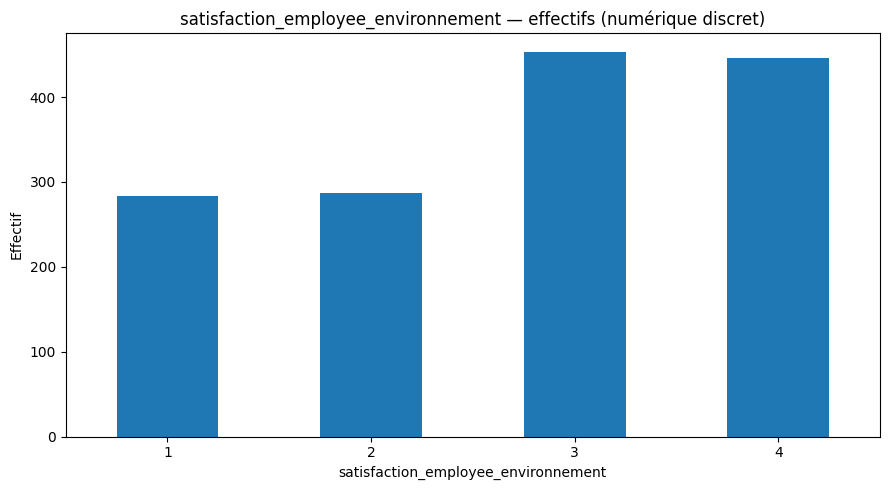

<Figure size 900x500 with 0 Axes>

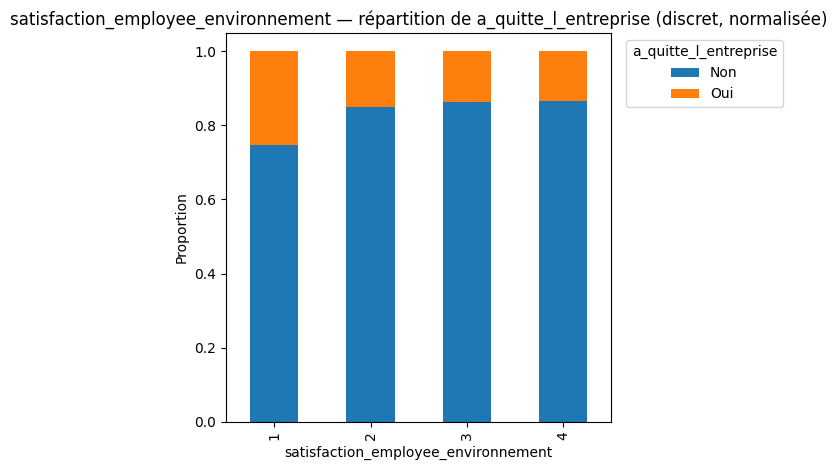

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


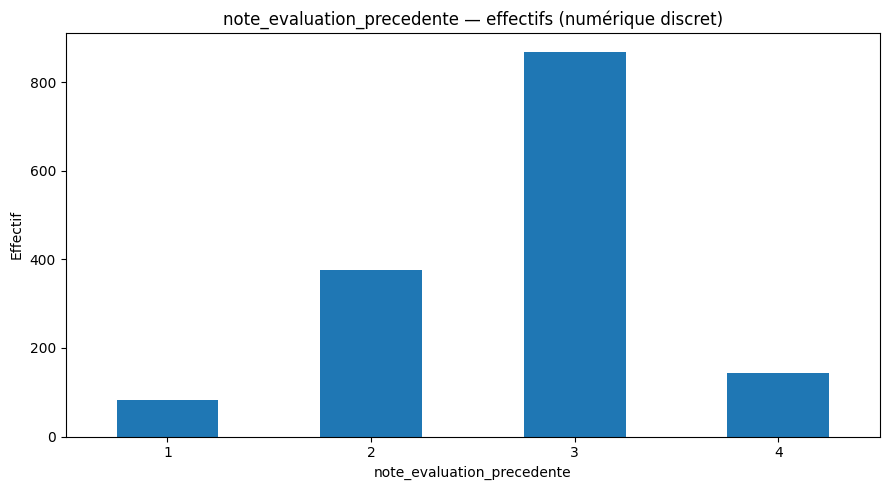

<Figure size 900x500 with 0 Axes>

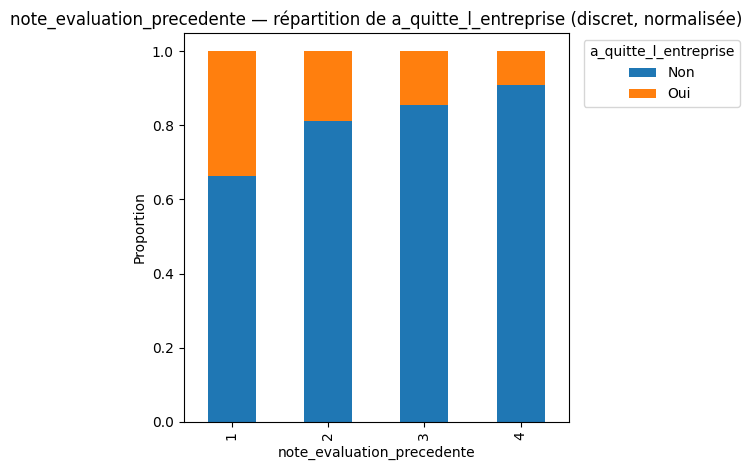

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


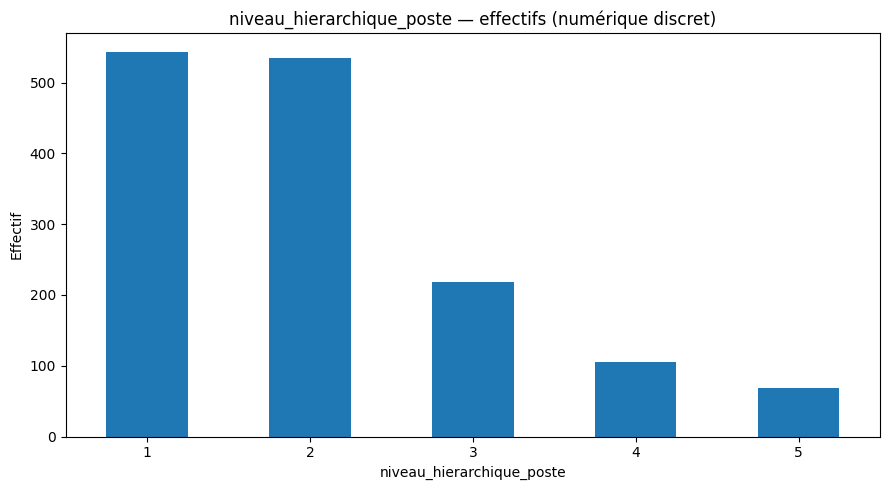

<Figure size 900x500 with 0 Axes>

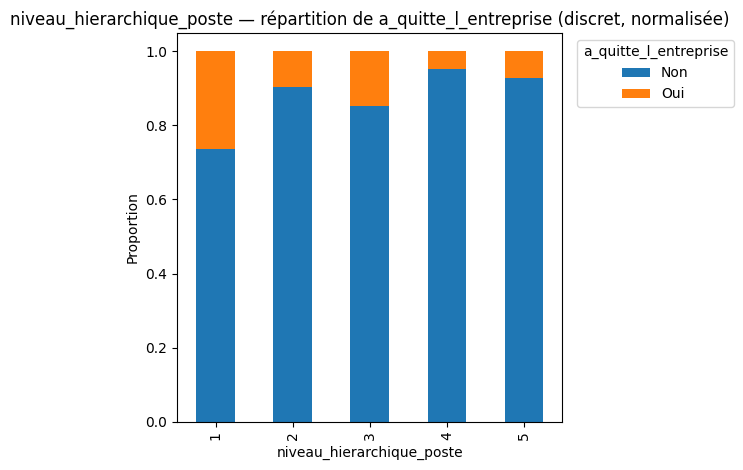

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


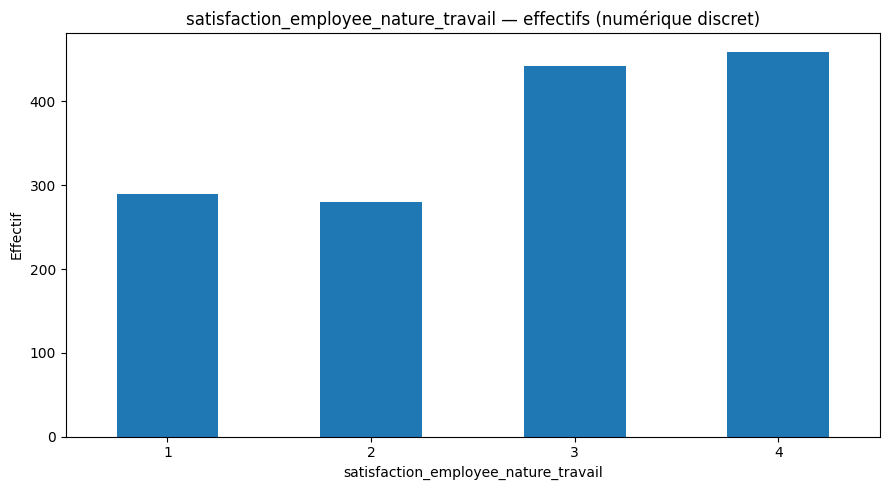

<Figure size 900x500 with 0 Axes>

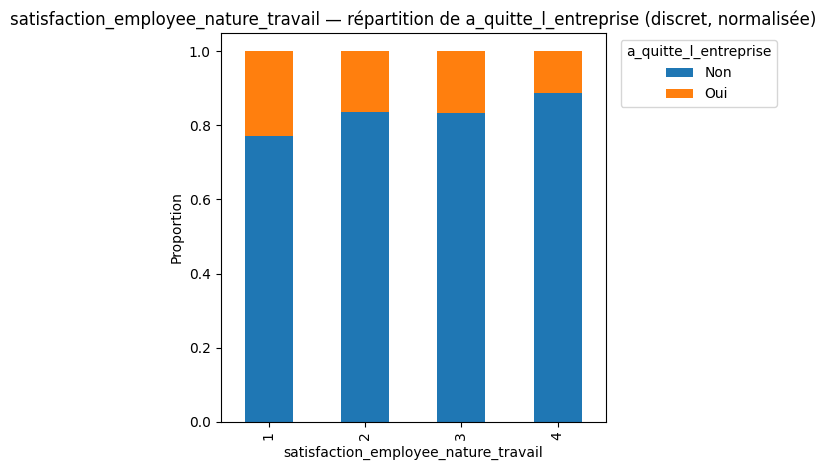

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


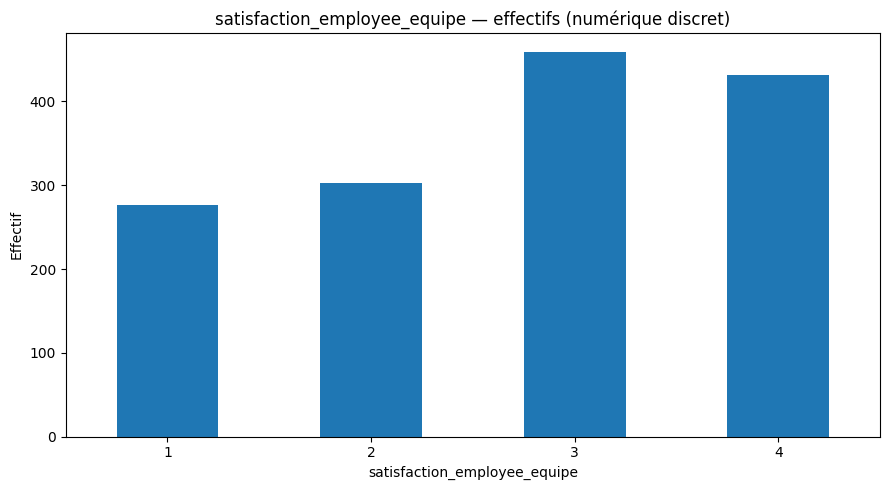

<Figure size 900x500 with 0 Axes>

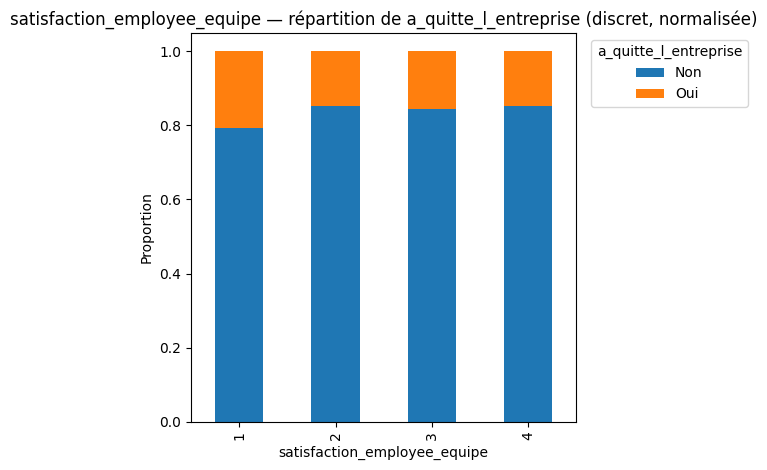

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


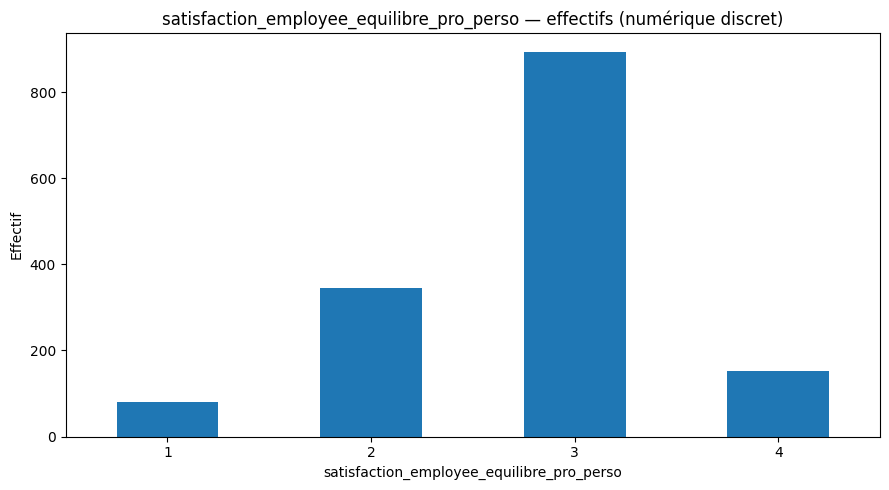

<Figure size 900x500 with 0 Axes>

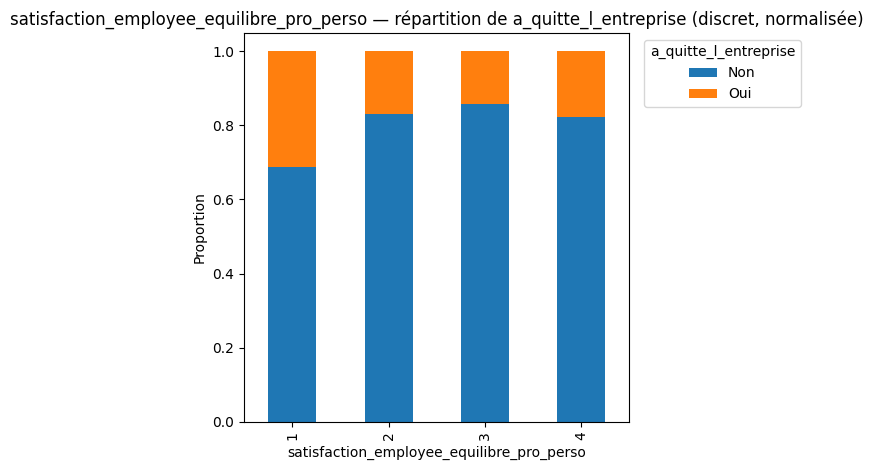

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


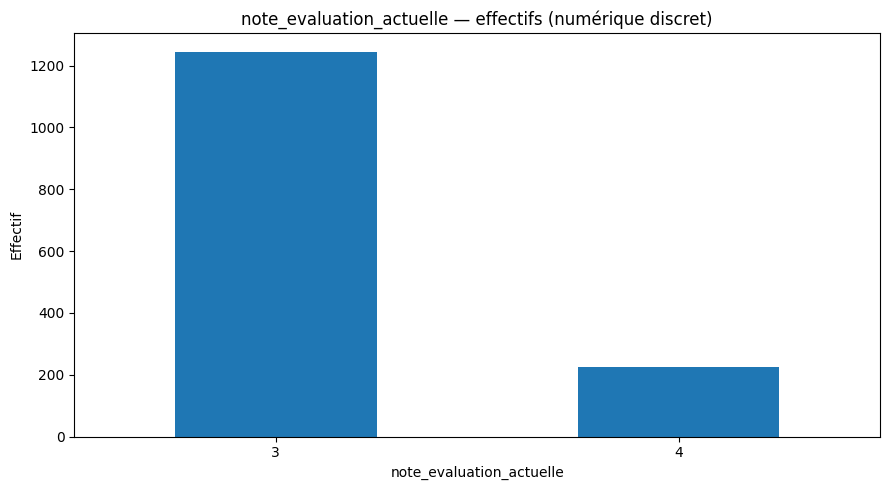

<Figure size 900x500 with 0 Axes>

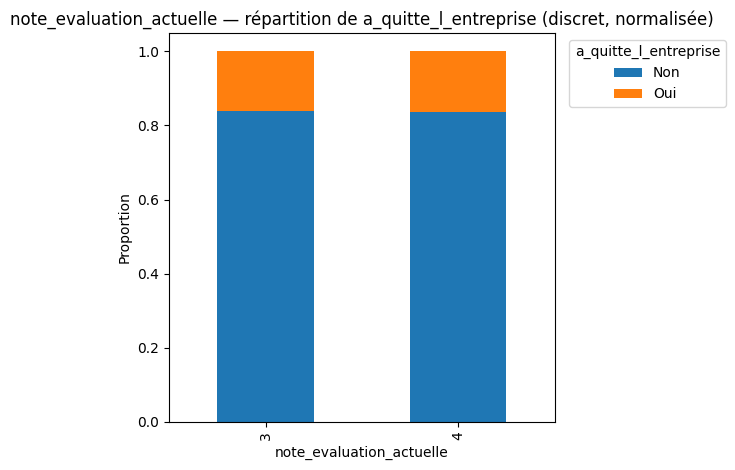

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


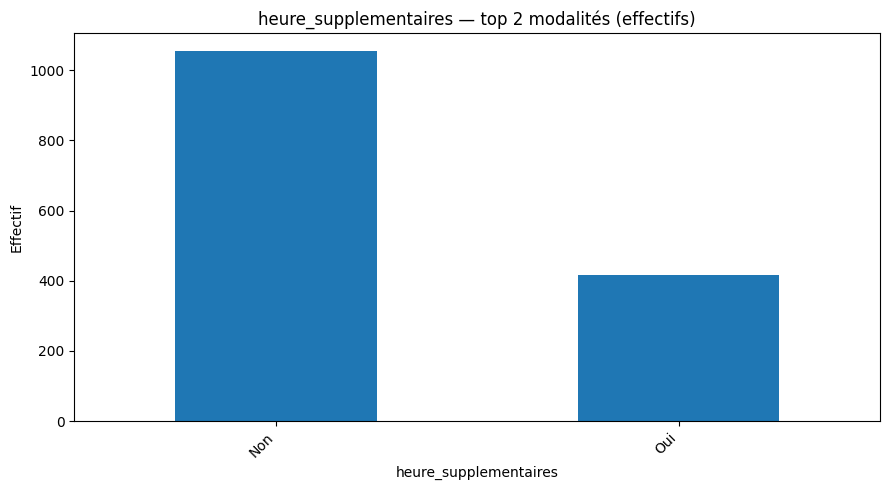

<Figure size 900x500 with 0 Axes>

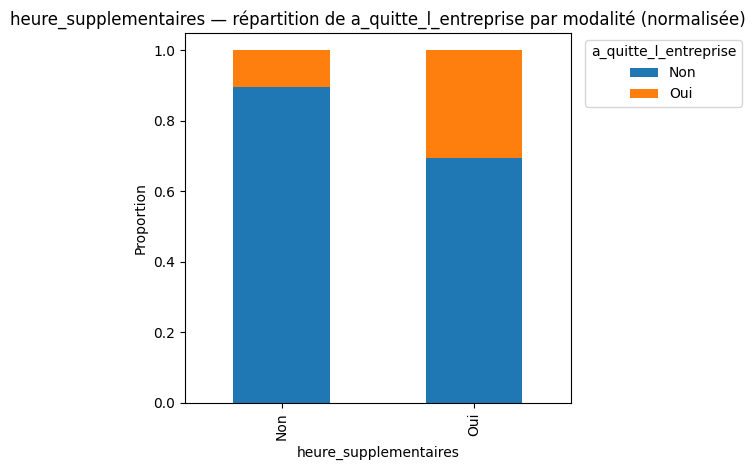

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


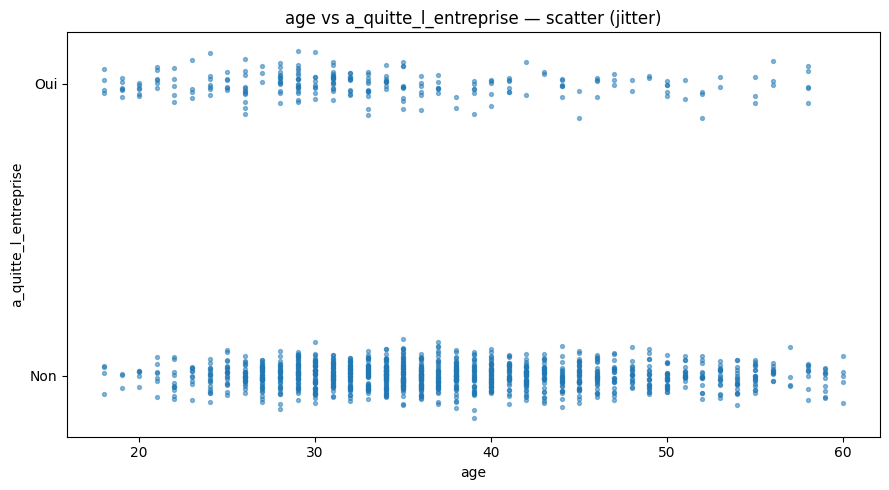

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


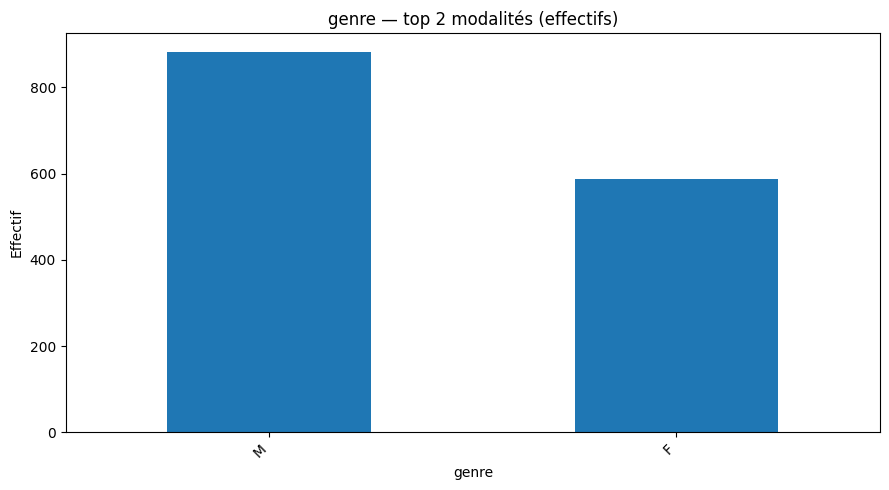

<Figure size 900x500 with 0 Axes>

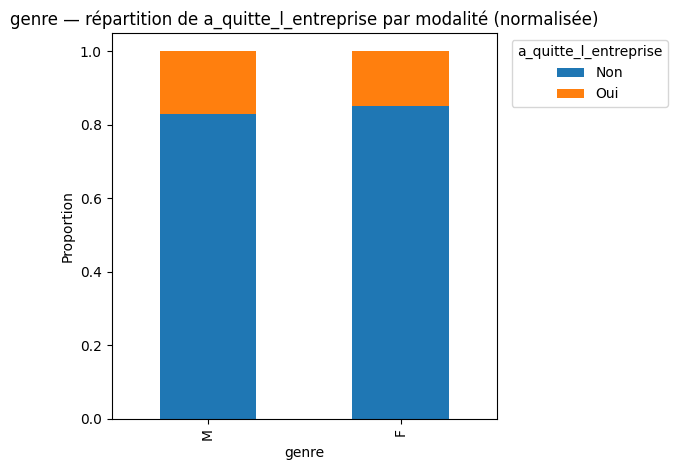

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


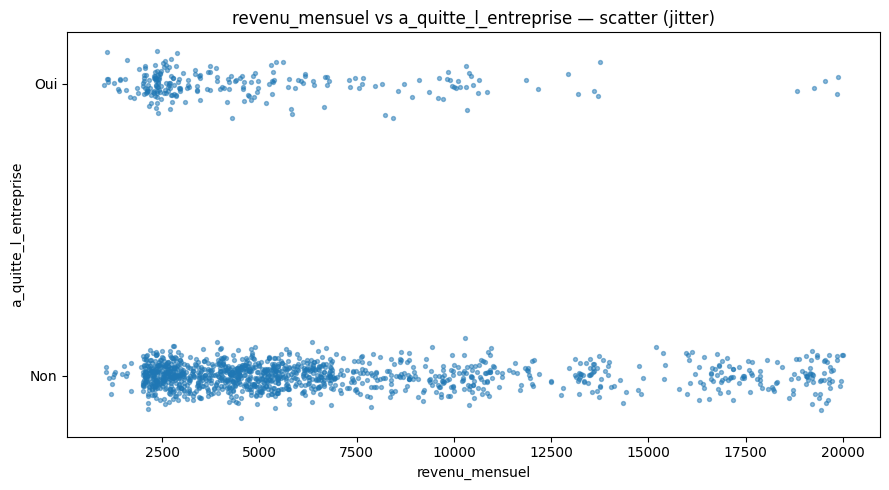

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


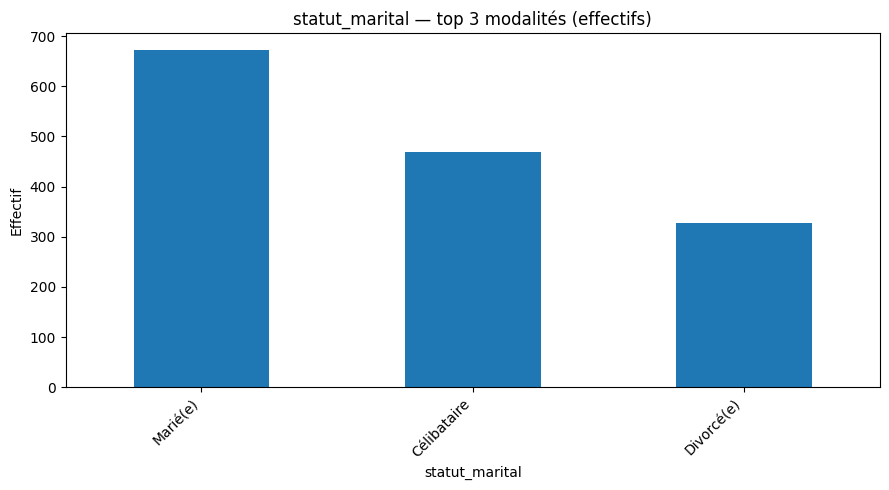

<Figure size 900x500 with 0 Axes>

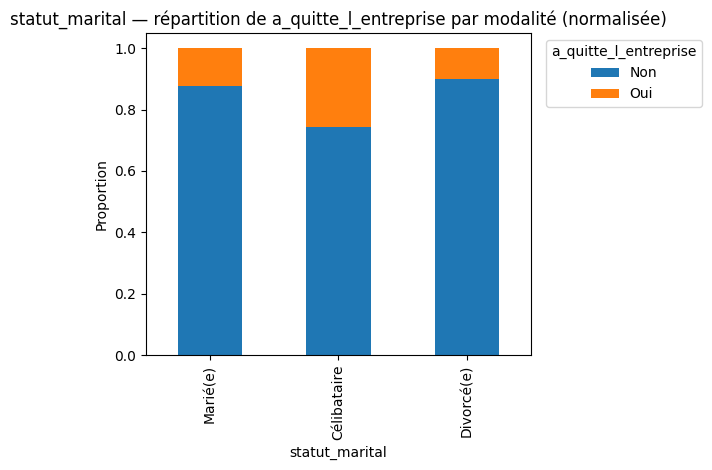

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


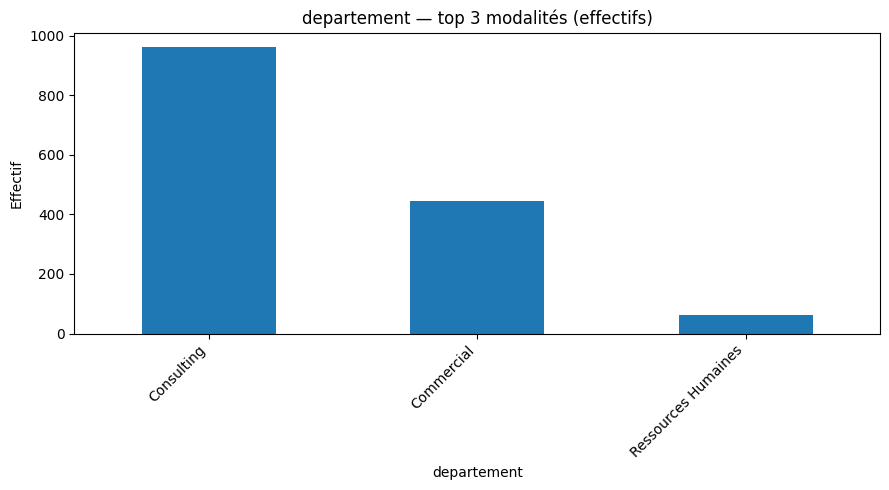

<Figure size 900x500 with 0 Axes>

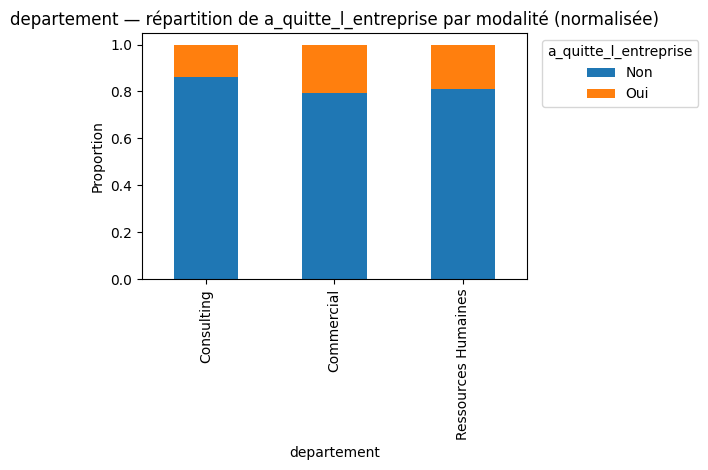

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


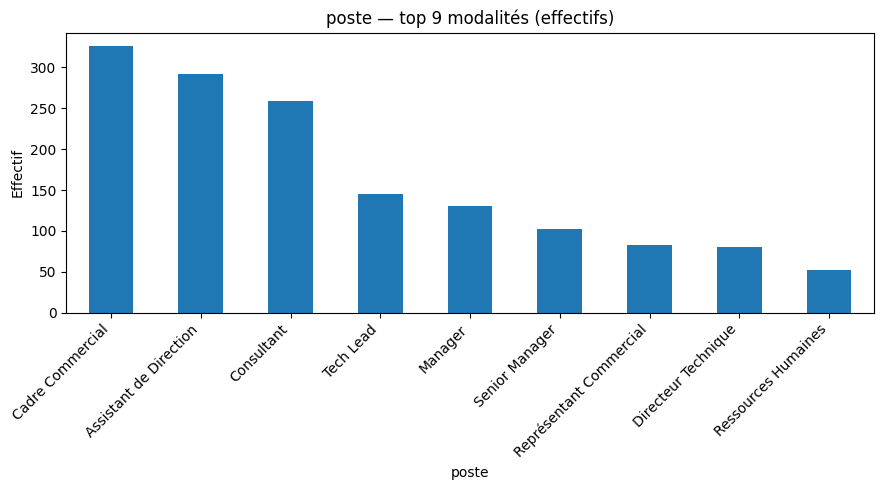

<Figure size 900x500 with 0 Axes>

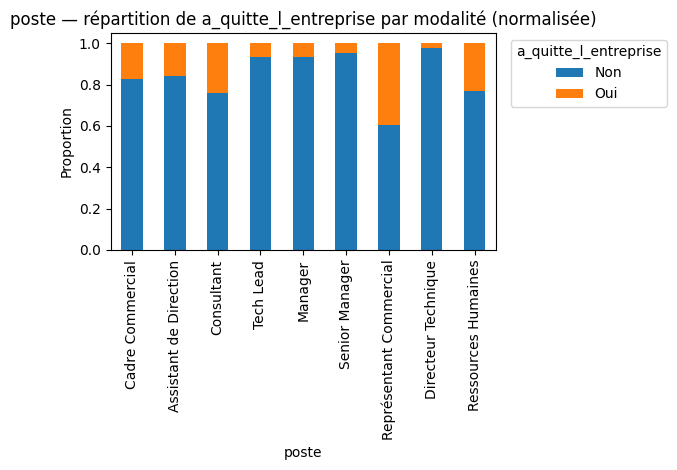

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


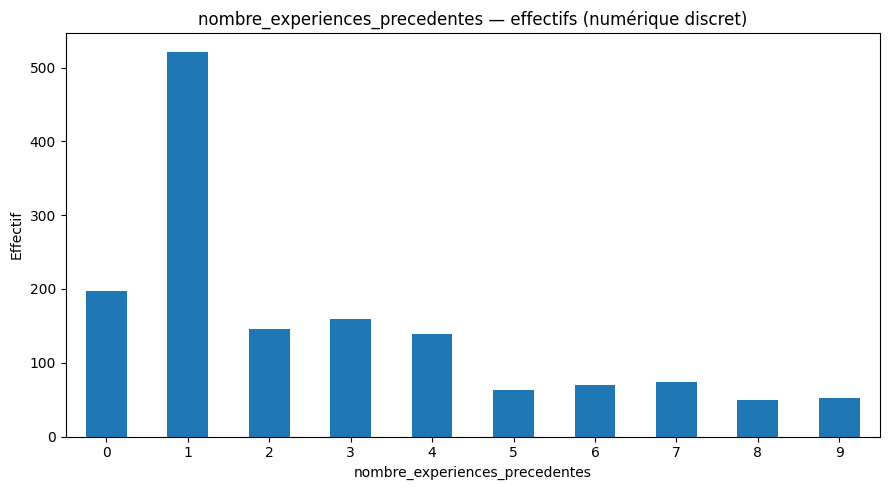

<Figure size 900x500 with 0 Axes>

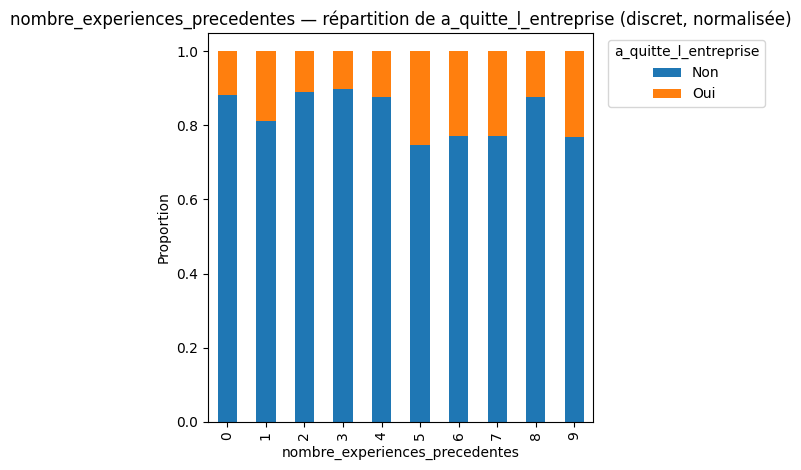

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


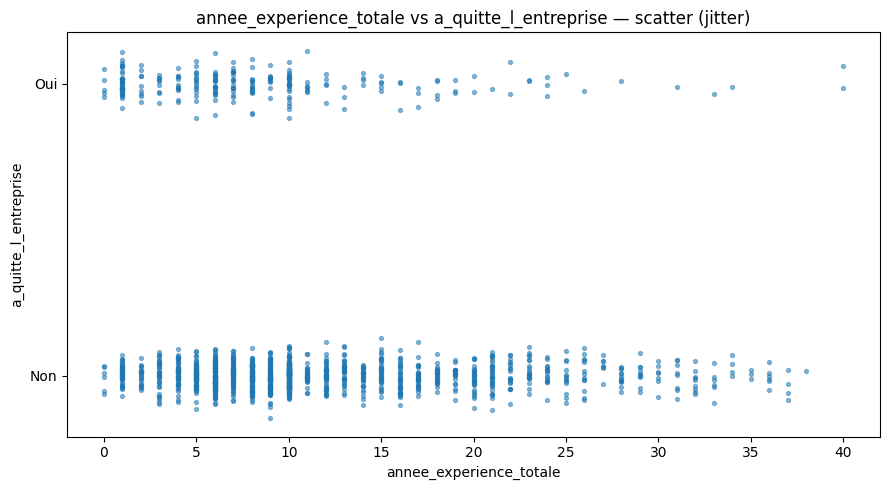

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


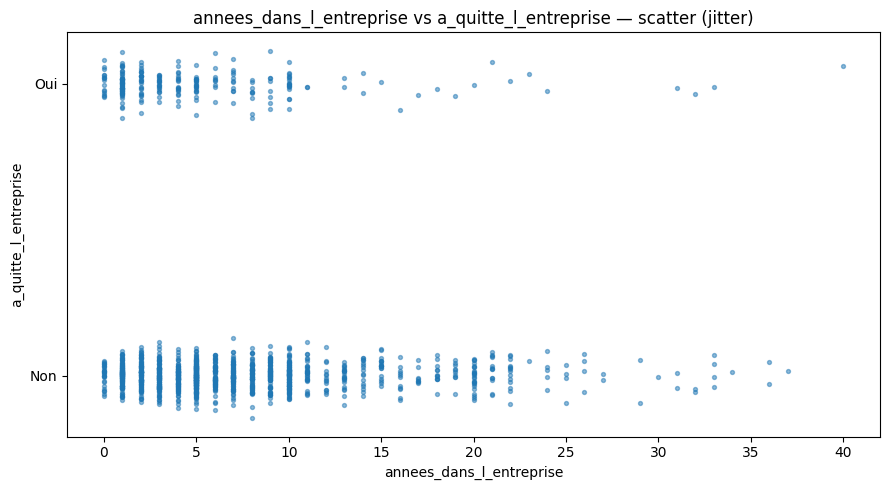

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


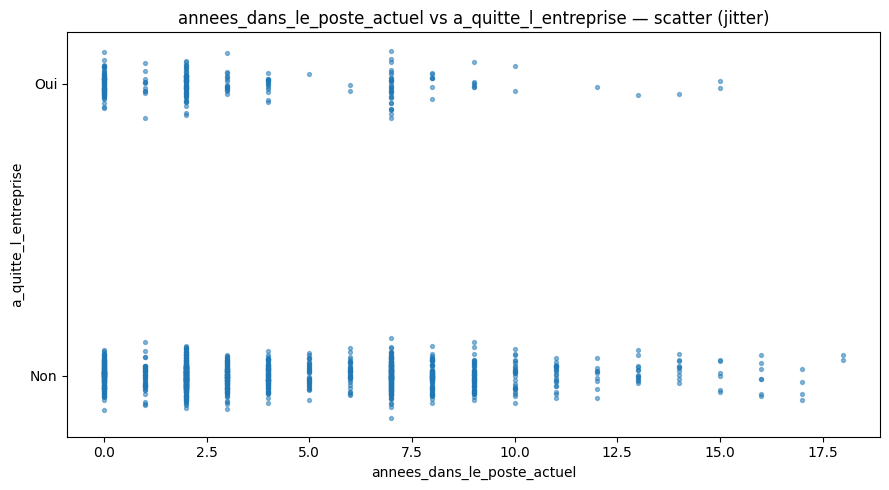

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


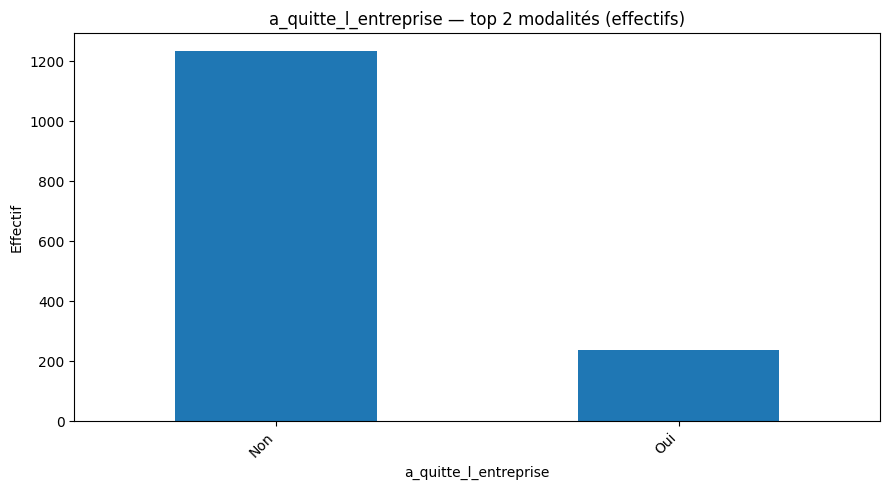

<Figure size 900x500 with 0 Axes>

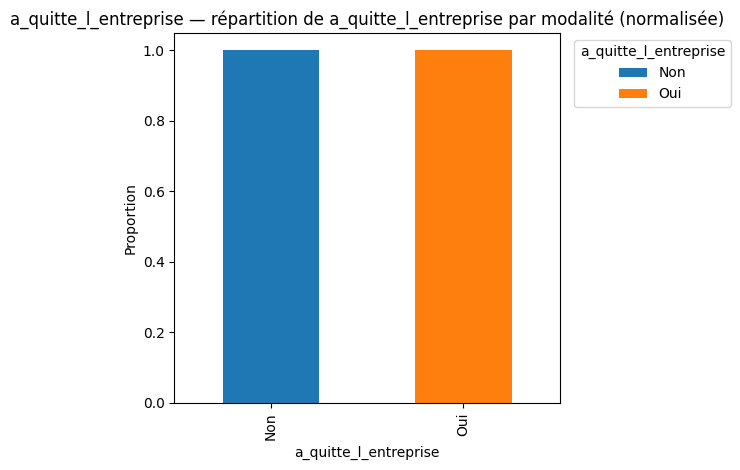

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


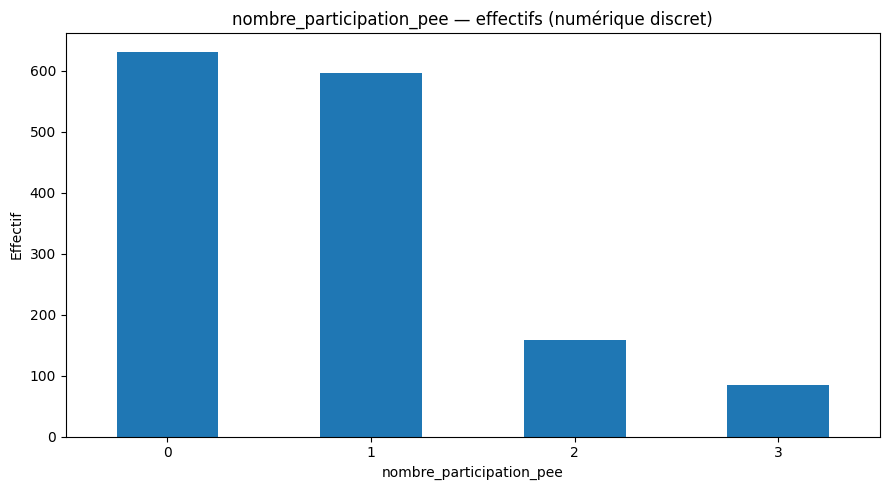

<Figure size 900x500 with 0 Axes>

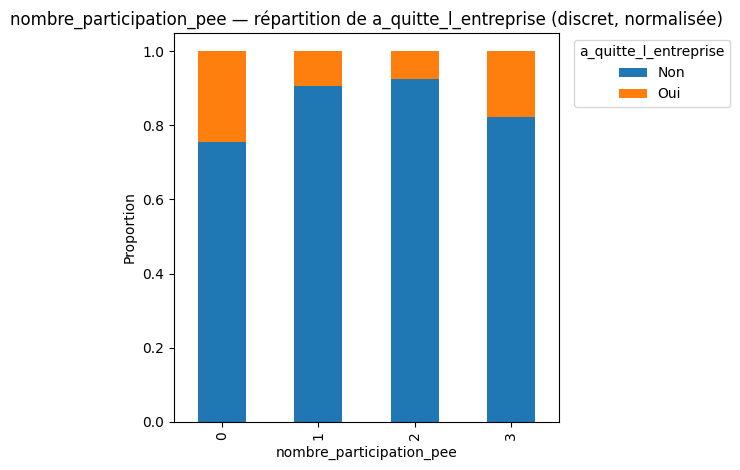

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


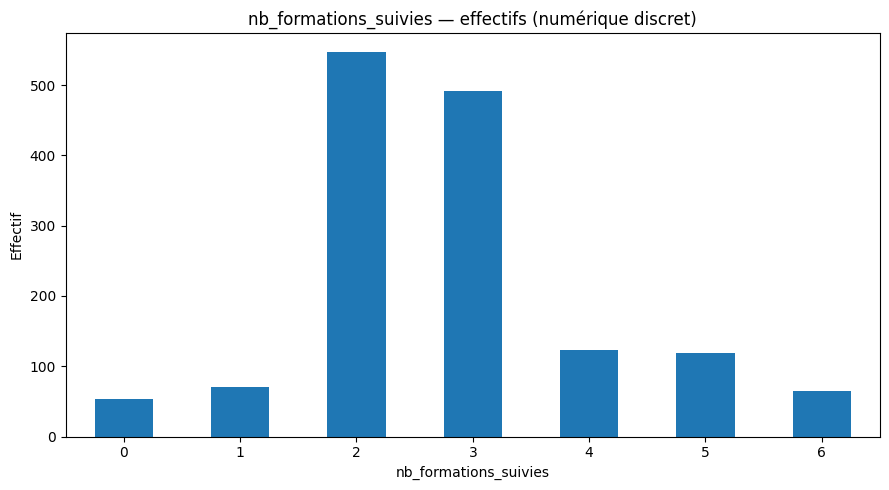

<Figure size 900x500 with 0 Axes>

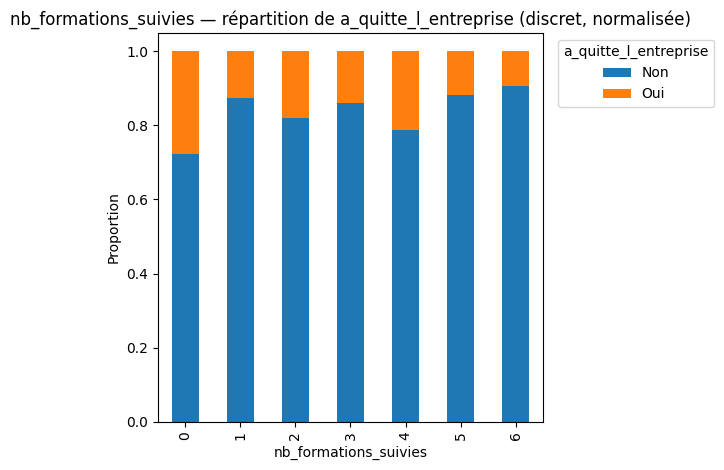

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


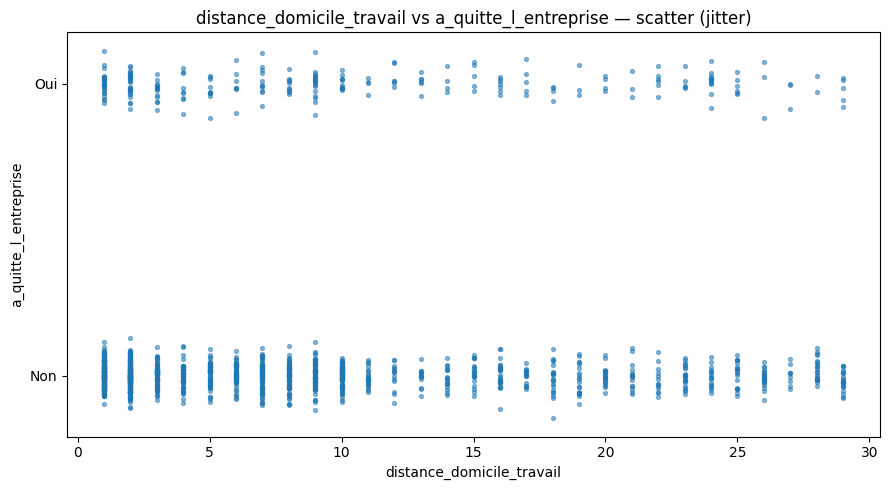

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


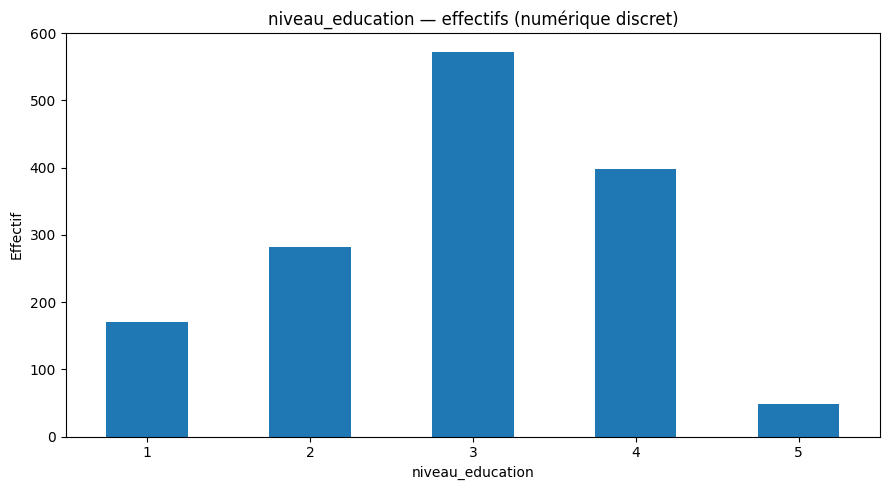

<Figure size 900x500 with 0 Axes>

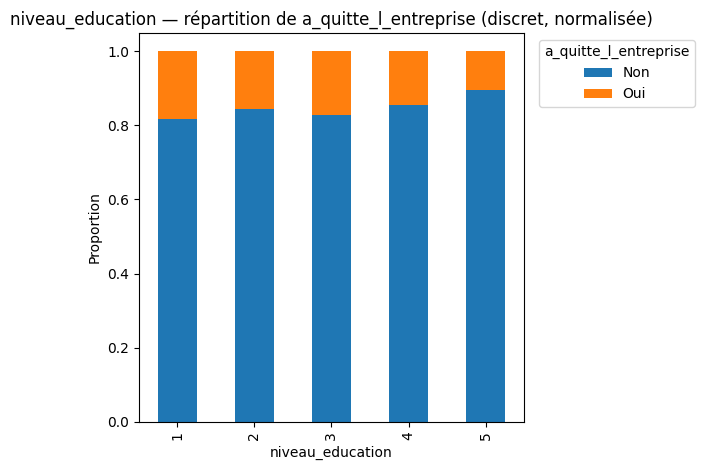

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


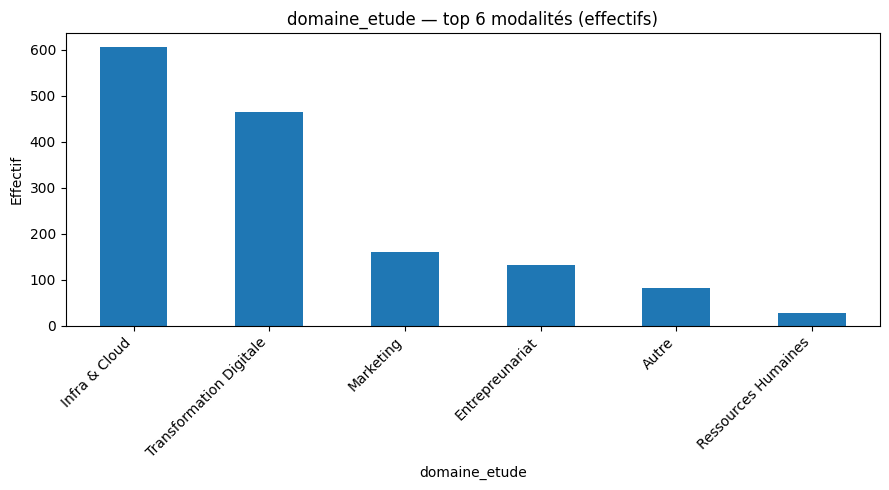

<Figure size 900x500 with 0 Axes>

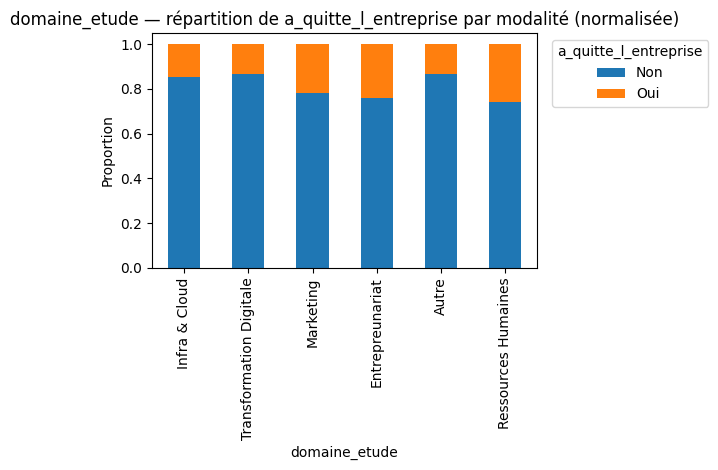

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


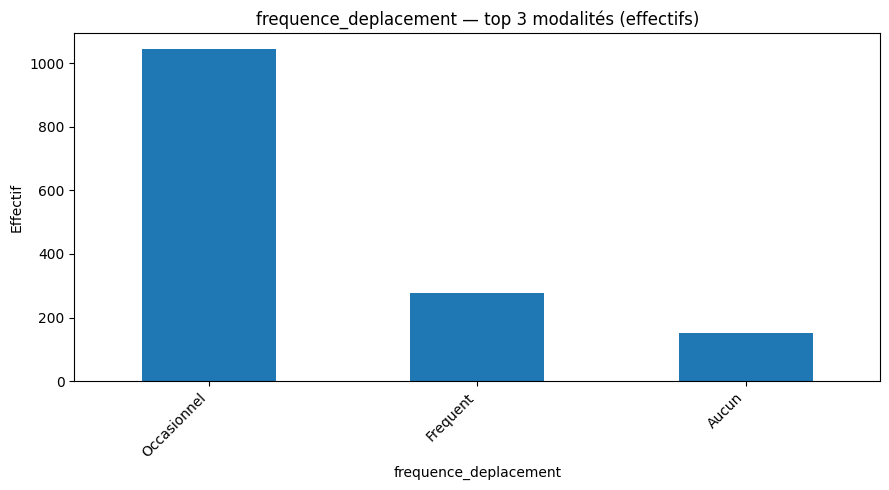

<Figure size 900x500 with 0 Axes>

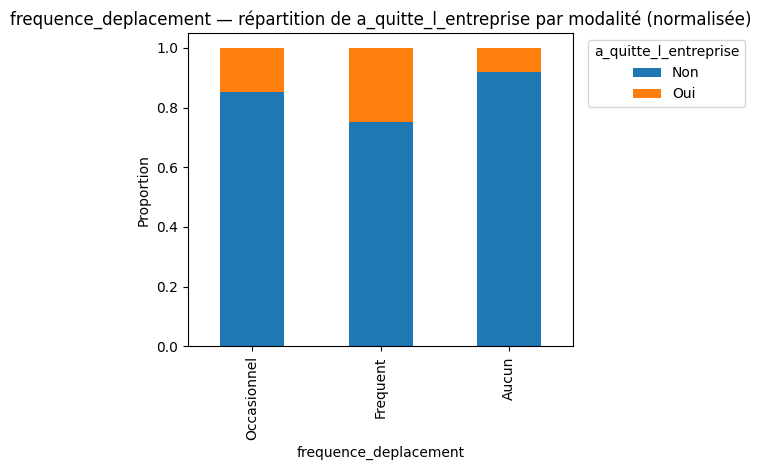

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


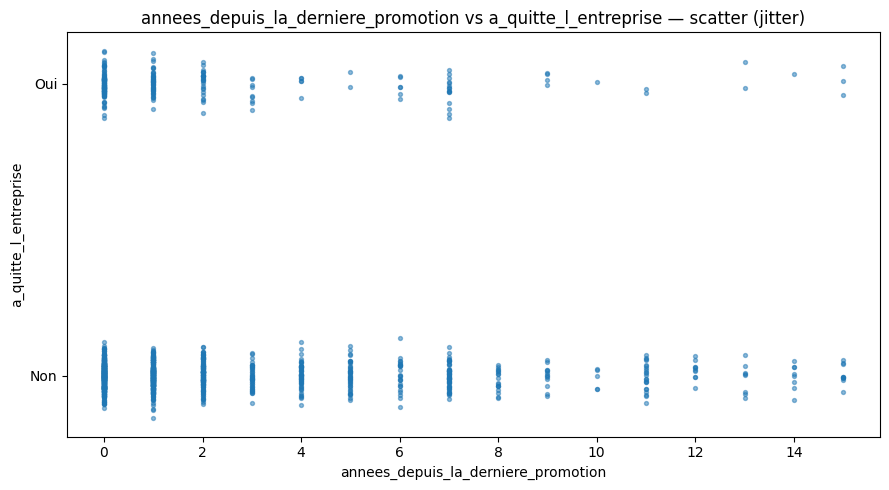

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


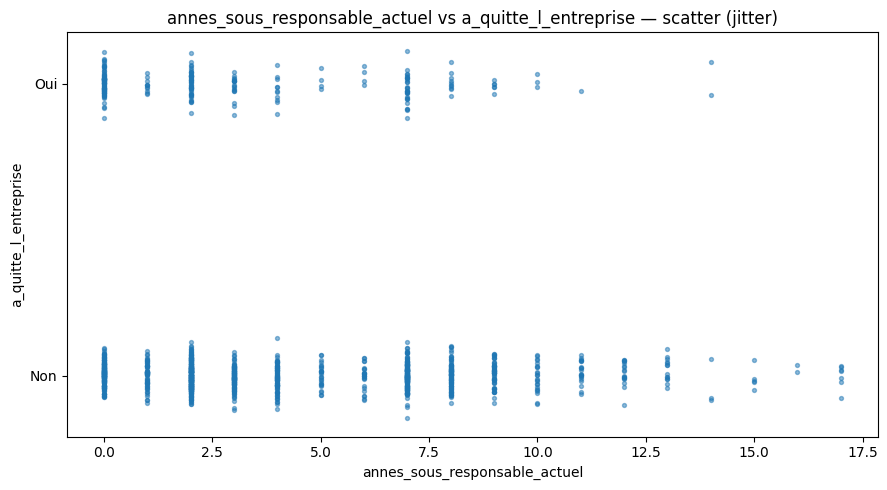

C:\Users\thoma\AppData\Local\Temp\ipykernel_61760\3506161625.py:39: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_qual = is_bool_dtype(s) or is_categorical_dtype(s) or is_string_dtype(s)


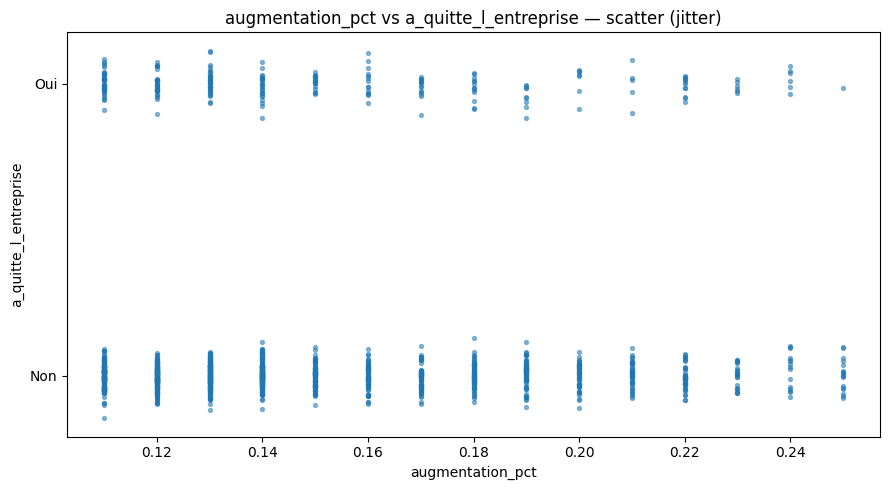

In [54]:
auto_plots(
    data,
    target="a_quitte_l_entreprise",
    id_cols=[],      
    top_n=20,
    bins="auto"
)

# Extraction du fichier dans le dossier data pour être récupéré dans le prochain notebook

In [52]:
data.to_csv(
    "data/jeu_donnee_RH_complet_transforme.csv", index=False, encoding="utf-8"
)